# **Notes** 
### Purpose: Calculate the dynamical trend in TXx and TXm for ERA5
#### Based on temperature anomalies rather than absolute temperatures to avoid a bias towards May

# **Preparation**

In [1]:
import numpy as np # for storing vector and matrix data
import matplotlib.pyplot as plt # to plot figures
import netCDF4 as nc #to read netCDF files
import cartopy.crs as ccrs # to plot maps
# (ergens in test ook: import cartopy as cart)
import cartopy.feature as cf
# from matplotlib import ticker
import scipy.io
from scipy.stats import pearsonr # voor persistence
import scipy.stats as stats
# from cartopy.util import add_cyclic_point
import os
from datetime import datetime, timedelta
import xarray as xr
import pickle

# **Functions**

In [2]:
def load_data(path,*variables_to_add):
  """
Provide the path to a file and the variables you want to extract
  """
  data = nc.Dataset(path, mode='r')
  variable_list = []
  for variable in variables_to_add:
    var =data.variables[variable][:]
    variable_list.append(var)
  return variable_list

In [3]:
def plot_variablet(lat, lon, variable,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [4]:
def extract_area(S, N, W, E, lat, lon, variable,event = False):
    """
    This function slices the data given the S, N, W, E bounds. Use event = True if there are only two dimensions (since then there is no time dimension), this means after using this
    function you need to use event[0] to get the data
    """
    # Change longitude data to go from -180 to 180
    for i in range(len(lon)):
        if lon[i] > 180:
          lon[i] = lon[i] - 360
        else:
          lon[i] = lon[i]

    # Calculate the index of the bounds
    sIndex = np.argmin(np.abs(lat - S))
    nIndex = np.argmin(np.abs(lat - N))
    wIndex = np.argmin(np.abs(lon - W))
    eIndex = np.argmin(np.abs(lon - E))

    if event:
        variable = np.expand_dims(variable, axis = 0)

    if wIndex > eIndex: # If the west index is higher than the east index, think of the right side of the world map as left boundary and vice versa
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = np.concatenate((lon[wIndex:], lon[:eIndex + 1]))
        variableSlice = np.concatenate((variable[:, sIndex: nIndex + 1, wIndex:], variable[:, sIndex: nIndex + 1, :eIndex + 1]), axis = 2)

    else:
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = lon[wIndex: eIndex + 1]
        variableSlice = variable[:, sIndex: nIndex + 1, wIndex: eIndex + 1]

    return latSlice, lonSlice, variableSlice

In [5]:
def temperature_trends__TXx_TXm(max_temp_data,adjusted_yearlength, start_year, end_year):
    """
    Needs to use the maximum daily temperature data (TASMAX),note that instead of looping through the years, you could also just do np.mean(...,axis = 1)
    because the o.g. reshaped data is still (years,months,lat,lon) (or lon/lat), so than you would get (years,lat,lon) 
    """
    amount_of_years = (end_year - start_year) + 1
    reshaped_data = max_temp_data.reshape(amount_of_years,adjusted_yearlength,max_temp_data.shape[1],max_temp_data.shape[2])
    list_for_Txx_values = []
    list_for_Txm_values = []

    for i in range(amount_of_years):
        filtered_data = reshaped_data[i,:,:,:]
        max_per_season = np.max(filtered_data,axis = 0)
        list_for_Txx_values.append(max_per_season)
        mean_per_season = np.mean(filtered_data, axis = 0)
        list_for_Txm_values.append(mean_per_season)

    array_for_TXx = np.array(list_for_Txx_values)
    array_for_TXm = np.array(list_for_Txm_values)
    
    return array_for_TXx, array_for_TXm

In [6]:
def regression_temperature_trend(GWD_list,temperature_trend_array):

    # Create empty arrays for the regression outputs
    shape_1 = temperature_trend_array.shape[1]
    shape_2 = temperature_trend_array.shape[2]

    slope_array = np.zeros((shape_1,shape_2))
    intercept_array = np.zeros((shape_1,shape_2))
    rvalue_array = np.zeros((shape_1,shape_2))
    pvalue_array = np.zeros((shape_1,shape_2))
    stderr_array = np.zeros((shape_1,shape_2))

    for i in range(shape_1):
        for j in range(shape_2):
            values_at_specific_coordinates = temperature_trend_array[:, i, j] # Find the values for all years in 1 grid cell
            slope, intercept, rvalue, pvalue, stderr = stats.linregress(GWD_list, values_at_specific_coordinates)
            
            # Store the regression outputs in the empty arrays
            slope_array[i, j] = slope
            intercept_array[i, j] = intercept
            rvalue_array[i, j] = rvalue
            pvalue_array[i, j] = pvalue
            stderr_array[i, j] = stderr

    return slope_array,intercept_array,rvalue_array,pvalue_array,stderr_array

In [7]:
def lists_for_era5_dates(final_year,final_month,final_day):
    """
    Creates lists with all months and years in the complete ERA5 data, taking into account leap days (schrikkeldagen)
    """
    start_date_all_era5_data = datetime(1950, 1, 1) # Is included
    end_date_all_era5_data = datetime(final_year,final_month,final_day) # Is included
    delta_time = timedelta(days=1)

    date_list_basic = []
    current_date = start_date_all_era5_data
    while current_date <= end_date_all_era5_data:
        date_list_basic.append(current_date)
        current_date += delta_time
    #date_strings = [date.strftime('%Y-%m-%d') for date in date_list_basic]
    month_list = [date.month for date in date_list_basic]
    year_list = [date.year for date in date_list_basic]

    return month_list, year_list


In [8]:
def extract_years_and_months_era5(era5_data,desired_start_month,desired_end_month,desired_start_year,desired_end_year,list_with_all_months,list_with_all_years):
    """
    Slice era5 data based on the months and years, months and years that are used as input variable will be included as well
    """
    if era5_data.shape[0] != len(list_with_all_months):
        print ("Error: Amount of days in the data and list with all dates are not the same")
    
    list_for_filtered_era5_data = []
    list_for_filtered_years = []
    list_for_filtered_months = []
    for i in range(era5_data.shape[0]):
        month_at_index = list_with_all_months[i]
        year_at_index = list_with_all_years[i]
        if month_at_index >= desired_start_month and month_at_index <= desired_end_month and year_at_index >= desired_start_year and year_at_index <= desired_end_year:
            data_to_select = era5_data[i,:,:]
            list_for_filtered_era5_data.append(data_to_select)
            list_for_filtered_years.append(year_at_index)
            list_for_filtered_months.append(month_at_index)
    array_selected_era5_data = np.array(list_for_filtered_era5_data)

    return array_selected_era5_data, list_for_filtered_years, list_for_filtered_months

In [9]:
def mean_weighted(data):
    """
    Parameters
    ----------
    data : data
         data.
    """
    ## Calculate global-mean surface temperature (GMST)
    cos_lat_2d = np.cos(np.deg2rad(data['lat'])) * xr.ones_like(data['lon']) # effective area weights
    mean_ = ((data * cos_lat_2d).sum(dim=['lat','lon']) /
                 cos_lat_2d.sum(dim=['lat','lon']))
    return mean_

In [10]:
def global_warming_degree_function_era5_area_weighted(temp_data_path,list_of_years, start_year, end_year, variable = "t2m"):
    """
    Hardcodes that its a 5 year centred running average, moet temp_data van het hele jaar
    laatste if niet nodig want zegt dat maar 65 jaar doet (tot 2014) maar era5 data en year list lopen tot 2024 dus de year list loopt gwn naar 2015
    doet weighted mean van de gegeven variable, hardcodes dat lat en lon heet (dus als variables in data lattitude en longitude hebt = aanpasses)
    door for i in range(amount_of_years) hardcodes ook dat in 1950 begint!
    """
    #Open the NetCDF file with xarray
    dataset = xr.open_dataset(temp_data_path)

    #Calculate the area weighted mean
    weighted_mean = mean_weighted(dataset[variable])

    #Transform the xarray DataArray into a list
    daily_mean_list = weighted_mean.values.tolist()


    amount_of_years = (end_year - start_year) + 1
    list_for_finalized_averages = []
    list_for_GWD = []

    list_for_reshaped_data = []
    day = 0
    for i in range(amount_of_years):
        list_for_data_per_year = []
        condition_variable = True
        while condition_variable == True:
            data_to_add = daily_mean_list[day]
            list_for_data_per_year.append(data_to_add)
            day = day + 1
            if list_of_years[day] != list_of_years[day-1]: #deze vergelijken met vorige omdat al day+1 hebt gedaan
                list_for_reshaped_data.append(list_for_data_per_year)
                condition_variable = False
            #if day == (temp_data.shape[0]): #niet -1 omdat hierboven al day + 1 hebt gedaan
                #condition_variable = False

    for i in range(amount_of_years):
        if i == 0:
            indexes = [0,1,2]
        elif i == 1:
            indexes = [0,1,2,3]
        elif i == (amount_of_years-1): #laatste
            indexes = [i-2,i-1,i]
        elif i == (amount_of_years-2): #(ook i nog minder hoog dus drm zelfde als vorige)
            indexes = [i-2,i-1,i,i+1]
        else:
            indexes = [i-2,i-1,i,i+1,i+2]
        
        list_for_means_per_year = []
        for index in indexes:
            list_to_analyse = list_for_reshaped_data[index]
            array_to_analyse = np.array(list_to_analyse)
            mean_for_year = np.mean(array_to_analyse)
            list_for_means_per_year.append(mean_for_year)
        combined_mean = (sum(list_for_means_per_year))/(len(list_for_means_per_year))
        list_for_finalized_averages.append(combined_mean)

    for average in list_for_finalized_averages:
        GWD_value = average - list_for_finalized_averages[-1]
        list_for_GWD.append(GWD_value)
    
    return list_for_GWD

In [11]:
def euclidian_distance(data, event):
  """
Calculates the euclidian distance for each day in the data compared to a given single event, gives an array (~list) of all the distances in chronological order
  """
  return np.sqrt(np.sum((data - event)**2, axis = (1, 2)))

In [12]:
def determine_analogues_era5(euclidian_distances, target_number_of_analogues,analogue_seperation_range,list_months,list_years,desired_start_month,desired_end_month,event_is_in_data = True):
  """
  Determine the best analogues. Give an array of all unsorted euclidan distances. The analogue_seperation_range determines how many days have to seperate
  the different analogues (if analogue_seperation_range = 5, the fifth day after an analogue can also still not be a new analogue(dus die dag mag ook niet)).
  Target_number_of_analogues is how many analogues are selected. Returns the indexes of the best analogues in the original data, and the euclidian distances corresponding to the analogues.
  Give semi-filtered data to euclidian_distances: filtered on years but all months, so the seperation range doesn't continue to count in the next season
  Should give semi-filtered lists of months and years as well??
  """
  distance_index_dictionary = {value: index for index, value in enumerate(euclidian_distances)} # Gives the index in the original euclidian distances list for a value in the sorted list
  sorted_distances = np.sort(euclidian_distances) # sort the distances from low to high euclidian distances
  analogues_index_list = [] # create a list to save the indexes of the selected analogues
  euclidian_distance_list = [] # create a list to save the euclidian distances of the selected analogues
  selected_analogue_years = []
  if event_is_in_data == False:
    i = 0
    if sorted_distances[0] == 0:
      print ("WARNING: event does seem to be in data, while event_is_in_data == False (zelf)")
    while len(analogues_index_list) < target_number_of_analogues and (i < len(euclidian_distances)):
      differences= []
      index = distance_index_dictionary[sorted_distances[i]]
      month = list_months[index]
      year = list_years[index]
      if len(analogues_index_list) == 0:
        if month >= desired_start_month and month <= desired_end_month:
          analogues_index_list.append(index)
          euclidian_distance_list.append(sorted_distances[i])
          selected_analogue_years.append(year)
        i = i + 1
      else:
        if month >= desired_start_month and month <= desired_end_month:
          for item in analogues_index_list:
            difference = (index-item)
            if difference < (-1*analogue_seperation_range) or difference > analogue_seperation_range:
              differences.append(2) #goed
            elif difference >= (-1*analogue_seperation_range) and difference <= (analogue_seperation_range):
              differences.append(1) #niet goed
          if min(differences) == 2:
            analogues_index_list.append(index)
            euclidian_distance_list.append(sorted_distances[i])
            selected_analogue_years.append(year)
            i = i + 1
          elif min(differences) == 1:
            i = i + 1
        else:
          i = i + 1

  elif event_is_in_data == True: #Need to make sure the selected analogues are also 5 days away from the event, eventhough it is not a selecgted analogue 
    event_index = distance_index_dictionary[sorted_distances[0]]
    analogues_index_list.append(event_index)
    i=1 #index counter
    if sorted_distances[0] != 0:
      print ("WARNING: event does not seem to be in data, while event_is_in_data == True (zelf)")
    while len(analogues_index_list) < (target_number_of_analogues+1) and (i < len(euclidian_distances)): #+1 omdat event er nu ook in en die later weghalen
      differences= []
      index = distance_index_dictionary[sorted_distances[i]]
      month = list_months[index]
      year = list_years[index]
      if len(analogues_index_list) == 0:
        if month >= desired_start_month and month <= desired_end_month:
          analogues_index_list.append(index)
          euclidian_distance_list.append(sorted_distances[i])
          selected_analogue_years.append(year)
        i = i + 1
      else:
        if month >= desired_start_month and month <= desired_end_month:
          for item in analogues_index_list:
            difference = (index-item)
            if difference < (-1*analogue_seperation_range) or difference > analogue_seperation_range:
              differences.append(2) #goed
            elif difference >= (-1*analogue_seperation_range) and difference <= (analogue_seperation_range):
              differences.append(1) #niet goed
          if min(differences) == 2:
            analogues_index_list.append(index)
            euclidian_distance_list.append(sorted_distances[i])
            selected_analogue_years.append(year)
            i = i + 1
          elif min(differences) == 1:
            i = i + 1
        else:
          i = i + 1
    analogues_index_list.pop(0)

  if len(analogues_index_list) < target_number_of_analogues:
    print ("WARNING: not enough data to find the required amount of analogues (zelf)")
  if len(analogues_index_list) != target_number_of_analogues:
    print ("WARNING: not the right amount of analogues has been found")
  return analogues_index_list,euclidian_distance_list,selected_analogue_years

In [13]:
def prep_temperature(data,filtered_yearlength,start_year,end_year):
        amount_of_years = (end_year - start_year) + 1
        reshaped_data = data.reshape(amount_of_years,filtered_yearlength,data.shape[1],data.shape[2])
        daily_means = np.mean(reshaped_data,axis=0)
        print (data.shape,reshaped_data.shape,daily_means.shape)
        counter = 0
        list_for_new_data = []
        for i in range(data.shape[0]):
                day_data = data[i]
                mean = daily_means[counter]
                new_data = day_data-mean
                list_for_new_data.append(new_data)
                counter = counter + 1
                if counter == 92:
                        counter = 0
        new_temp_array = np.array(list_for_new_data)
        print (new_temp_array.shape)
        return new_temp_array

In [14]:
def thermodynamical_correction_and_shuffling_function(semi_filtered_p_data,semi_filtered_t_data,season_p_data,season_t_data,analogues_seperation_range,semi_filtered_month_list,semi_filtered_year_list,season_start_month,season_end_month,start_year,gwd_list,season_filtered_year_list):
    """
    test
    """
    if semi_filtered_p_data.shape[0] != semi_filtered_t_data.shape[0]:
        print ("WARNING: the semi_filtered p and T data do not have the same amount of days")

    if season_p_data.shape[0] != season_t_data.shape[0]:
        print ("WARNING: the season_filtered p and T data do not have the same amount of days")
        
    one_percent_of_season_days = (season_p_data.shape[0])*0.01
    analogue_target_amount = round(one_percent_of_season_days)
    print (f"The amount of days was: {season_p_data.shape[0]}, 1% is: {one_percent_of_season_days}, which was rounded to: {analogue_target_amount}")
    list_for_Ts_arrays = []
    list_for_lists_with_indexes_for_shuffling = []
    for i in range(season_p_data.shape[0]): #for every day in the season
        #Find the top 1% analogues
        event_day = season_p_data[i,:,:]
        euclidian_distances_array = euclidian_distance(semi_filtered_p_data,event_day)
        analogues_indexes,euclidian_distances,selected_analogue_years_list = determine_analogues_era5(euclidian_distances_array,analogue_target_amount,analogues_seperation_range,semi_filtered_month_list,semi_filtered_year_list,season_start_month,season_end_month,event_is_in_data = True) # Event is elke keer zomer dag dus zit in data
        list_for_temperature_fields_analogues = []
        if len(analogues_indexes) != analogue_target_amount:
            print ("WARNING: not enough analogues where find for calculating the b(X) (zelf)")

        #Find the matching temperature fields
        for index in analogues_indexes:
            temp_field = semi_filtered_t_data[index,:,:]
            list_for_temperature_fields_analogues.append(temp_field)
        temp_fields_analogues = np.array(list_for_temperature_fields_analogues) #For a single day, the temperaturefields of the top 1% analogues (shape: anlogue/lat/lon (of lon/lat))

        #Find the matching GWD values (the GWD values of the years in which the analogues are found)
        list_for_selected_gwd_values = []
        for year in selected_analogue_years_list:
            index_in_gwd = year - start_year
            gwd_value = gwd_list[index_in_gwd]
            list_for_selected_gwd_values.append(gwd_value)

        #Perform the regression
        shape1 = temp_fields_analogues.shape[1]
        shape2 = temp_fields_analogues.shape[2]
        slope_array = np.zeros((shape1,shape2))
        for a in range(shape1):
            for b in range(shape2):
                values_at_coordinates = temp_fields_analogues[:,a,b] # Find the values of all analogues in 1 specific gridcell
                slope, intercept, rvalue, pvalue, stderr = stats.linregress(list_for_selected_gwd_values, values_at_coordinates)
                slope_array[a, b] = slope
        
        #Multiply the created b(X) (the slope_array) with the GWD value of the summer day that is set as the event
        year_of_event_day = season_filtered_year_list[i] #checken of niet al iets met i gedaan hebt (tussen nu en begin for loop)
        index_in_gwd2 = year_of_event_day - start_year
        gwd_value_event = gwd_list[index_in_gwd2]
        thermo_dynamical_correction_array = slope_array*gwd_value_event

        #Subtract the correction from the original to create Ts (event_day is nog pressure dus kan niet die gebruiken!)
        event_day_T = season_t_data[i,:,:]
        Ts_array = event_day_T - thermo_dynamical_correction_array
        list_for_Ts_arrays.append(Ts_array)

        #Find/save the indexes for the best 3 analogues for the shuffling
        list_for_shuffling_indexes = []
        for number in range(3):
            index_shuffle = analogues_indexes[number]
            list_for_shuffling_indexes.append(index_shuffle)
        list_for_lists_with_indexes_for_shuffling.append(list_for_shuffling_indexes)
        
    Ts_array_finalized = np.array(list_for_Ts_arrays)

    #Ts_array_finalized = prep_temperature(Ts_array_finalized,92,1950,2023)
    
    list_for_lists_corrected_indexes = [] # the indexes in list_for_lists_with_indexes_for_shuffling are for semi-filtered but you need season indexes
    for lijst in list_for_lists_with_indexes_for_shuffling:
        list_for_corrected_indexes = []
        for item in lijst:
            counter = 0
            match_condition = False
            while match_condition == False and counter < season_t_data.shape[0]:
                indexed_field = semi_filtered_t_data[item]
                season_field = season_t_data[counter]
                if np.array_equal(indexed_field, season_field) == True:
                    list_for_corrected_indexes.append(counter)
                    match_condition = True
                else:
                    counter = counter + 1
                    if counter == season_t_data.shape[0]:
                        print ("WARNING: the field in the season data corresponding to the analogue field in semi-filtered data was not found? (ZELF)")
        list_for_lists_corrected_indexes.append(list_for_corrected_indexes)

    #Shuffle the Ts timeseries into three new time series
    time_series_list1 = []
    time_series_list2 = []
    time_series_list3 = []
    for day in range(Ts_array_finalized.shape[0]):
        list_for_day = list_for_lists_corrected_indexes[day]
        index_day_1 = list_for_day[0]
        data_day_1 = Ts_array_finalized[index_day_1]
        time_series_list1.append(data_day_1)
        index_day_2 = list_for_day[1]
        data_day_2 = Ts_array_finalized[index_day_2]
        time_series_list2.append(data_day_2)
        index_day_3 = list_for_day[2]
        data_day_3 = Ts_array_finalized[index_day_3]
        time_series_list3.append(data_day_3)
    time_series1 = np.array(time_series_list1)
    time_series2 = np.array(time_series_list2)
    time_series3 = np.array(time_series_list3)
    time_series1 = prep_temperature(time_series1,92,1950,2023)
    time_series2 = prep_temperature(time_series2,92,1950,2023)
    time_series3 = prep_temperature(time_series3,92,1950,2023)

    return time_series1,time_series2,time_series3

In [15]:
def mean_weighted_masked(data,mask):
    """
    Parameters
    ----------
    data : data
         data.
    """
    ## Calculate global-mean surface temperature (GMST)
    mask_af = np.squeeze(mask)
    cos_lat_2d = np.cos(np.deg2rad(data['lat'])) * xr.ones_like(data['lon']) # effective area weights
    if cos_lat_2d.shape != mask_af.shape:
        print (f"WARNING: shapes of mask ({mask_af}) and cos_lat2d  ({cos_lat_2d.shape}) do no match (in mean_weigted2 (zelf))")
    cos_lat_2d_masked = cos_lat_2d*mask_af
    mean_ = ((data * cos_lat_2d).sum(dim=['lat','lon']) /
                 cos_lat_2d_masked.sum(dim=['lat','lon']))
    return mean_

In [16]:
def area_averaged_trend(data,lat,lon,landmask_path,S,N,W,E):
    """
    Calculates the area weighted mean land area trend of a region using a land mask
    """

    #Load the mask and extract the selected region for the mask and actual data
    latm,lonm,mask_data = load_data(landmask_path,"lat","lon","tx")
    latm_box,lonm_box,mask_box = extract_area(S,N,W,E,latm,lonm,mask_data,event = False)
    latd_box,lond_box,data_box = extract_area(S,N,W,E,lat,lon,data,event = True)

    #Prepare mask
    min_data = np.min(mask_box)
    if min_data == -9999.0:
        mask_box = np.where(mask_box == -9999.0, np.nan, mask_box)
    mask = mask_box/mask_box
    if mask.shape != data_box.shape:
        print ("WARNING: shape of mask and data do not match (zelf)")
    
    #Perform analyses and plot to check
    masked_data = data_box*mask
    plot_variablet(latd_box,lond_box,masked_data[0],"test","test")

    #Turn into xarray and take area weighted average
    time_indices = np.arange(masked_data.shape[0])  # Because you used event = True in extract area both now have three dimensions
    data_xr_array = xr.DataArray(masked_data, dims=['time', 'lat', 'lon'], coords={'time': time_indices, 'lat': latd_box, 'lon': lond_box})
    mean_trend = mean_weighted_masked(data_xr_array,mask)
    mean_list = mean_trend.values.tolist()
    print (f"weighted mean = {mean_list}, normal mean = {np.mean(masked_data)}")

    return mean_list

In [17]:
def prep_streamfunction(data):
    """
    doen nadat bijgesneden
    """
    list_for_new_data = []
    for i in range(data.shape[0]):
        data_day = data[i,:,:]
        day_mean = np.mean(data_day)
        new_data = data_day - day_mean
        list_for_new_data.append(new_data)
    new_array = np.array(list_for_new_data)
    
    return new_array

# **Set-up**

In [18]:
#Select: "regridded" or "original", Als original data doet hebt kans dat kleiner gebied moet doen want doet EU data en dat data geupdate is dus dat lijst langer moet zijn met dates
data_to_use = "regridded"

In [19]:
#The latest date in the ERA5 dataset, for the regridded data its 2024, 2, 29 (which is automatically selected if data_to_use = "regridded")
final_year_og = 2024
final_month_og = 3
final_day_og = 31

In [20]:
#Select the months and years that will be analysed
desired_start_monthV = 3 # 6 voor JJA en 3 voor MAM
desired_end_monthV = 5 # 8 voor JJA en 5 voor MAM
desired_start_yearV = 1950 # 1950 for all data
desired_end_yearV = 2023 # 2014 for model comparison, 2023 is the last complete year

In [21]:
#Select the area for which to calculate the temperature trend (for original data zit een limit omdat EU data doet dus kan niet alles kiezen)
bboxT = [30,70,-30,30] #Pick borders like: [S,N,W,E] (T from temperature) for serious_run1 = [30,70,-30,30]

In [22]:
#Select the area in which to look for analogues!
bboxP = [30,60,-30,20] #Pick borders like: [S,N,W,E] (P from pressure)

In [23]:
#Select the area over which to average the trend
bboxA = [45,55,-5,15] #Pick borders like: [S,N,W,E] (A from average) for Vautard = [45,55,-5,15]

In [24]:
# Set the adjusted yearlenght
adjusted_yearlengthV = 92 # 92 voor JJA en MAM

In [25]:
#Set how to look for analogues (for the b(X) and shuffling)
analogues_seperation_rangeV = 6

In [26]:
# Where and how to save (zelf mapje al maken! (in prompt mkdir ...))
save_outputV = False
plot_outputV = True
save_pathV = '/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/era5_prepared_psi'
season_nameV = "MAM_anomaly3_test" #JJA or MAM
save_statisticsV = False
save_path_statisticsV = '/usr/people/noest/stage_folders/outputs/net/serious_run2/dynamical_trend/era5_prepared_psi'

# **Uitvoeren**

In [27]:
if data_to_use == "regridded":
    data_path_tmax = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_tmax_daily_regridded.nc"
    data_path_t2m = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_t2m_daily_regridded.nc"
    #data_path_msl = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_psi500_daily_regridded.nc"
    data_path_msl = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_psi500_daily_regridded_1950_2023.nc"
    land_mask_path = "/net/pc200246/nobackup/users/noest/landmask/landmask_day_regridded.nc"
    final_yearV = 2024
    final_monthV = 2
    final_dayV = 29
elif data_to_use == "original":
    data_path_tmax = "/net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_tmax_daily_eu.nc"
    #data_path_t2m = "/net/pc230042/nobackup/users/sager/nobackup_2_old/ERA5-CX-READY/era5_t2m_daily.nc"
    data_path_t2m = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_t2m_daily_regridded.nc"
    data_path_msl = "/net/pc200265/nobackup/users/pinto/phi500/era5_phi500.fixed.1degE.nc"
    land_mask_path = "/net/pc200246/nobackup/users/noest/landmask/landmask_day_tmax_highres.nc"
    final_yearV = final_year_og
    final_monthV = final_month_og
    final_dayV = final_day_og

In [28]:
#Determine the boundaries to use for the temperature trend
if data_to_use == "regridded":
    S1 = bboxT[0] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N1 = bboxT[1] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W1 = bboxT[2] # for serious_run1 = -30
    E1 = bboxT[3] # for serious_run1 = 30
elif data_to_use == "original":
    S1 = bboxT[1] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N1 = bboxT[0] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W1 = bboxT[2] # for serious_run1 = -30
    E1 = bboxT[3] # for serious_run1 = 30

In [29]:
#Determine the boundaries to use to look for analogues
if data_to_use == "regridded":
    S_P = bboxP[0] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N_P = bboxP[1] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W_P = bboxP[2] # for serious_run1 = -30
    E_P = bboxP[3] # for serious_run1 = 30
elif data_to_use == "original":
    S_P = bboxP[1] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N_P = bboxP[0] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W_P = bboxP[2] # for serious_run1 = -30
    E_P = bboxP[3] # for serious_run1 = 30

In [30]:
#Determine the boundaries to use for the average trend
if data_to_use == "regridded":
    S_A = bboxA[0] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N_A = bboxA[1] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W_A = bboxA[2] # for serious_run1 = -30
    E_A = bboxA[3] # for serious_run1 = 30
elif data_to_use == "original":
    S_A = bboxA[1] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N_A = bboxA[0] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W_A = bboxA[2] # for serious_run1 = -30
    E_A = bboxA[3] # for serious_run1 = 30

In [31]:
#Create lists with for every day, the month and the year it is in (taking into account leap days :))
list_with_months, list_with_years = lists_for_era5_dates(final_yearV,final_monthV,final_dayV)

In [32]:
#Calculate the GWD using the area weighted average as a running 5 year mean
gwd_era5 = global_warming_degree_function_era5_area_weighted(data_path_t2m,list_with_years,desired_start_yearV,desired_end_yearV)

In [33]:
#Load, slice and extract temperature data
tmax_lat,tmax_lon,tmax = load_data(data_path_tmax,"lat","lon","tmax")
lat_bboxT,lon_bboxT,tmax_all_days_bboxT = extract_area(S1, N1, W1, E1, tmax_lat,tmax_lon, tmax,event = False)
tmax_semi_filtered_bboxT, list_semi_filterd_years_t,list_semi_filterd_months_t = extract_years_and_months_era5(tmax_all_days_bboxT,1,12,desired_start_yearV,desired_end_yearV,list_with_months,list_with_years)
tmax_season_bboxT, list_season_filterd_years_t,list_season_filterd_months_t = extract_years_and_months_era5(tmax_all_days_bboxT,desired_start_monthV,desired_end_monthV,desired_start_yearV,desired_end_yearV,list_with_months,list_with_years)

In [34]:
#Load, slice and extract pressure data
msl_lat,msl_lon,msl_levels = load_data(data_path_msl,"lat","lon","stream")
msl = np.squeeze(msl_levels)
lat_bboxP,lon_bboxP,msl_all_days_bboxP_og = extract_area(S_P, N_P, W_P, E_P, msl_lat,msl_lon,msl,event = False)
msl_all_days_bboxP = prep_streamfunction(msl_all_days_bboxP_og)
msl_semi_filtered_bboxP, list_semi_filterd_years_p,list_semi_filterd_months_p = extract_years_and_months_era5(msl_all_days_bboxP,1,12,desired_start_yearV,desired_end_yearV,list_with_months,list_with_years)
msl_season_bboxP, list_season_filterd_years_p,list_season_filterd_months_p = extract_years_and_months_era5(msl_all_days_bboxP,desired_start_monthV,desired_end_monthV,desired_start_yearV,desired_end_yearV,list_with_months,list_with_years)

Error: Amount of days in the data and list with all dates are not the same
Error: Amount of days in the data and list with all dates are not the same


In [35]:
Ts1,Ts2,Ts3 = thermodynamical_correction_and_shuffling_function(msl_semi_filtered_bboxP,tmax_semi_filtered_bboxT,msl_season_bboxP,tmax_season_bboxT,analogues_seperation_rangeV,list_semi_filterd_months_p,list_semi_filterd_years_p,desired_start_monthV,desired_end_monthV,desired_start_yearV,gwd_era5,list_season_filterd_years_p)

The amount of days was: 6808, 1% is: 68.08, which was rounded to: 68
(6808, 33, 33) (74, 92, 33, 33) (92, 33, 33)
(6808, 33, 33)
(6808, 33, 33) (74, 92, 33, 33) (92, 33, 33)
(6808, 33, 33)
(6808, 33, 33) (74, 92, 33, 33) (92, 33, 33)
(6808, 33, 33)


In [36]:
# tmax extracted was:#lat_slice,lon_slice,tmax_extracted = extract_area(S1, N1, W1, E1, tmax_lat,tmax_lon, tmax_season,event = False)
Txx_era5_1, Txm_era5_1 = temperature_trends__TXx_TXm(Ts1,adjusted_yearlengthV, desired_start_yearV, desired_end_yearV)
Txx_era5_2, Txm_era5_2 = temperature_trends__TXx_TXm(Ts2,adjusted_yearlengthV, desired_start_yearV, desired_end_yearV)
Txx_era5_3, Txm_era5_3 = temperature_trends__TXx_TXm(Ts3,adjusted_yearlengthV, desired_start_yearV, desired_end_yearV)
mean_Txx_era5 = np.mean([Txx_era5_1, Txx_era5_2, Txx_era5_3], axis=0)
mean_Txm_era5 = np.mean([Txm_era5_1, Txm_era5_2, Txm_era5_3], axis=0)

In [37]:
slope_array_era5_Txx,intercept_array_era5_Txx,rvalue_array_era5_Txx,pvalue_array_era5_Txx,stderr_array_era5_Txx = regression_temperature_trend(gwd_era5,mean_Txx_era5)

In [38]:
slope_array_era5_Txm,intercept_array_era5_Txm,rvalue_array_era5_Txm,pvalue_array_era5_Txm,stderr_array_era5_Txm = regression_temperature_trend(gwd_era5,mean_Txm_era5)

In [39]:
if save_outputV == True:
    np.save(f"{save_pathV}/{season_nameV}_era5_TXx_slope_{data_to_use}_data_until_{desired_end_yearV}.npy",slope_array_era5_Txx) 
    np.save(f"{save_pathV}/{season_nameV}_era5_TXm_slope_{data_to_use}_data_until_{desired_end_yearV}.npy",slope_array_era5_Txm)
    lat_to_save = np.array(lat_bboxT)
    lon_to_save = np.array(lon_bboxT)
    np.save(f"{save_pathV}/{season_nameV}_era5_lat_extracted_{data_to_use}_data_until_{desired_end_yearV}.npy",lat_to_save) 
    np.save(f"{save_pathV}/{season_nameV}_era5_lon_extracted_{data_to_use}_data_until_{desired_end_yearV}.npy",lon_to_save)

In [40]:
if save_statisticsV == True:
    np.save(f"{save_path_statisticsV}/{season_nameV}_era5_TXx_stderr_{data_to_use}_data_until_{desired_end_yearV}.npy",stderr_array_era5_Txx) 
    np.save(f"{save_path_statisticsV}/{season_nameV}_era5_TXx_pvalue_{data_to_use}_data_until_{desired_end_yearV}.npy",pvalue_array_era5_Txx) 
    np.save(f"{save_path_statisticsV}/{season_nameV}_era5_TXm_stderr_{data_to_use}_data_until_{desired_end_yearV}.npy",stderr_array_era5_Txm) 
    np.save(f"{save_path_statisticsV}/{season_nameV}_era5_TXm_pvalue_{data_to_use}_data_until_{desired_end_yearV}.npy",pvalue_array_era5_Txm) 

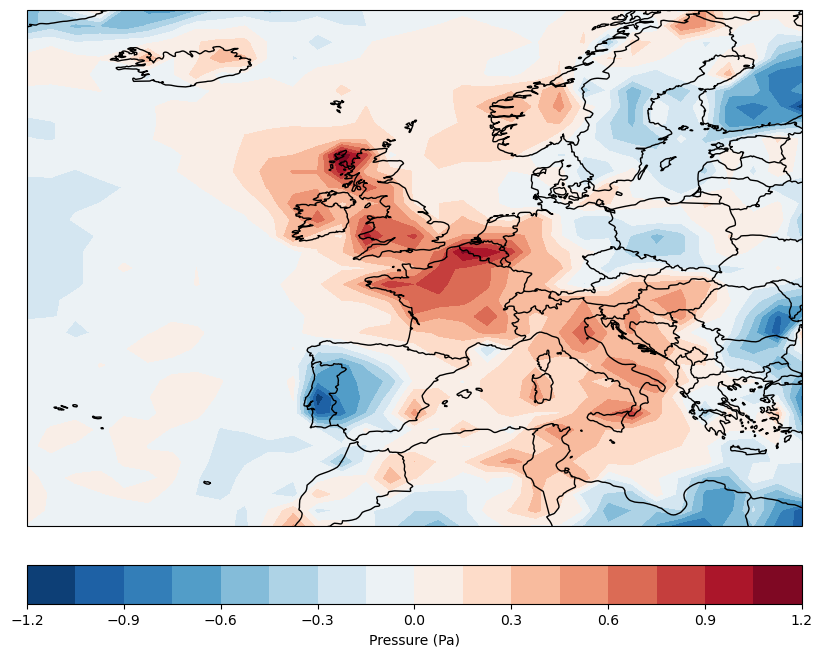

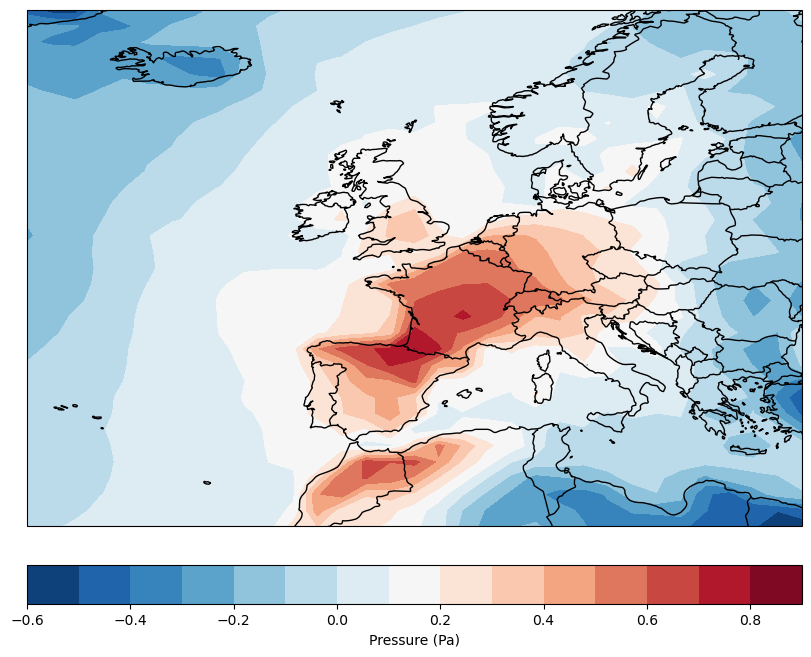

In [41]:
if plot_outputV == True:
    plot_variablet(lat_bboxT,lon_bboxT,slope_array_era5_Txx,"tset","test")
    plot_variablet(lat_bboxT,lon_bboxT,slope_array_era5_Txm,"tset","test")

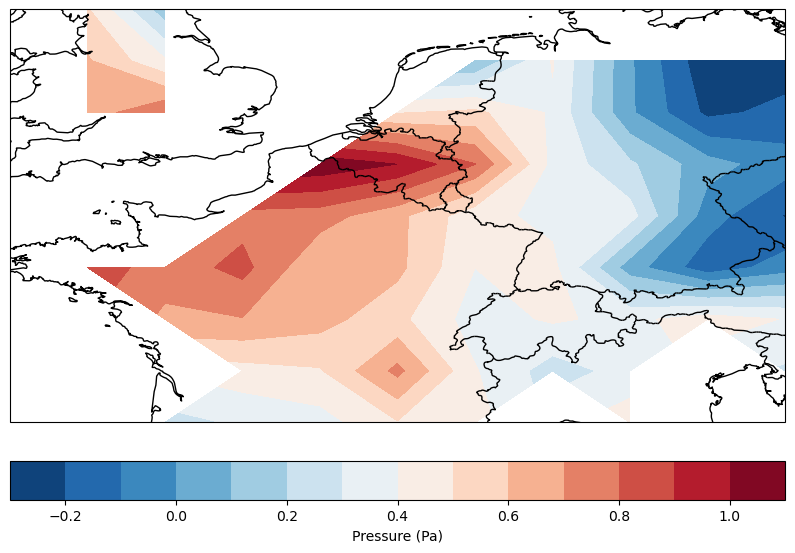

weighted mean = [0.393098800674043], normal mean = nan


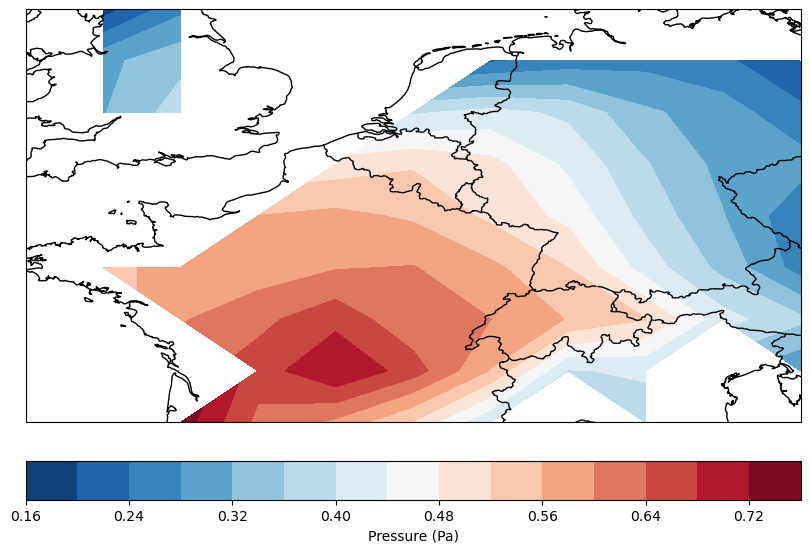

weighted mean = [0.44842561525672253], normal mean = nan


In [42]:
mean_Txx = area_averaged_trend(slope_array_era5_Txx,lat_bboxT,lon_bboxT,land_mask_path,S_A,N_A,W_A,E_A)
mean_Txm = area_averaged_trend(slope_array_era5_Txm,lat_bboxT,lon_bboxT,land_mask_path,S_A,N_A,W_A,E_A)

In [43]:
if save_outputV == True:
    filenametxx = f"{save_pathV}/{season_nameV}_era5_meanTxxlist_{data_to_use}_data_until_{desired_end_yearV}.pkl"
    with open(filenametxx, 'wb') as f:
        pickle.dump(mean_Txx, f)
    filenametxm = f"{save_pathV}/{season_nameV}_era5_meanTxmlist_{data_to_use}_data_until_{desired_end_yearV}.pkl"
    with open(filenametxm, 'wb') as f:
        pickle.dump(mean_Txm, f)

In [44]:
# import pickle
# filename = f"{save_pathV}/era5_GWD_{data_to_use}_data_until_{desired_end_yearV}.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(gwd_era5, f)

In [45]:
# def load_lists_from_file(measurement_name, stack_name):
#     filename = f"/content/drive/MyDrive/Colab Notebooks/Research Project/plume_output/{measurement_name}_{stack_name}.pkl"
#     with open(filename, 'rb') as f:
#         loaded_lists = pickle.load(f)
#     return loaded_lists

# **Proberen**